# Network visualization

This notebook constructs a network visualization connecting bacterial species to KEGG pathways.

In [42]:
# Preliminaries
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def widen_notebook():
    display(HTML("<style>.container { width:100% !important; }</style>"))
widen_notebook()

In [43]:
# data files
!ls ../data/edges/lung-cancer

LC_KO_metadata.txt   edges_k5.txt         ranks.csv
edges.sh             microbe-metadata.txt


In [44]:
edges_txt = "../data/edges/lung-cancer/edges_k5.txt"
kegg_txt = "../data/edges/lung-cancer/LC_KO_metadata.txt"
microbes_txt = "../data/edges/lung-cancer/microbe-metadata.txt"

In [45]:
# Read data files into lists of dictionaries
def split_commas(line):
    return line.strip().split("\t")

def CSVtodicts(filename):
    f = open(filename)
    result = []
    headers = split_commas(f.readline())
    for line in f.readlines():
        values = split_commas(line)
        dictionary = dict(zip(headers, values))
        result.append(dictionary)
    return result

edges = CSVtodicts(edges_txt)
keggs = CSVtodicts(kegg_txt)
microbes = CSVtodicts(microbes_txt)

len(edges), len(keggs), len(microbes)

(1750, 1554, 350)

In [62]:
import pandas as pd
microbes = pd.read_table(microbes_txt)
keggs = pd.read_table(kegg_txt)
edges = pd.read_table(edges_txt)

# scrub dataframe
featureid = '#SampleID'

/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


In [83]:
d_col = 'C(Smoking_status)[T.Never]'
ew = "rank"

In [64]:
# scrub edges, because of R ...
edges['src'] = edges.src.apply(lambda x: int(x.replace('\"', '')))
edges['dest'] = edges.dest.apply(lambda x: x.replace('\"', ''))

In [65]:
select_microbes = list(set(edges.src.values))
select_kegg = list(set(edges.dest.values))

In [66]:
import seaborn as sns

In [67]:
np.min(microbes.set_index(featureid).loc[select_microbes, d_col].values), np.max(microbes.set_index(featureid).loc[select_microbes, d_col].values)

(nan, nan)

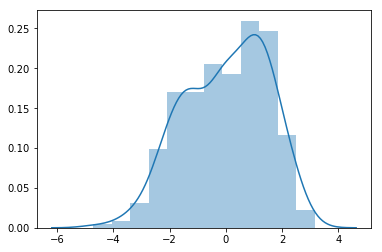

In [74]:
vals = microbes.set_index(featureid).loc[select_microbes, d_col]
sns.distplot(vals.dropna().values)

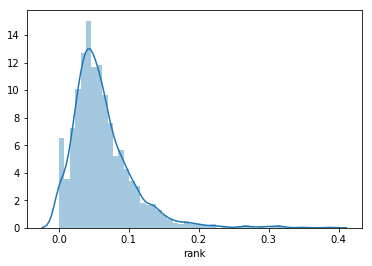

In [81]:
sns.distplot(edges['rank'])

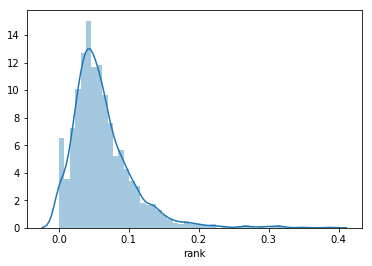

In [84]:
sns.distplot(edges[ew])

In [85]:
def abbreviate(x):
    return x.split('|')[-1]
abbreviate('k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname')

'o__Viruses_noname'

In [ ]:
microbe_dicts = microbes.T.to_dict().values()
kegg_dicts = keggs.T.to_dict().values()
edge_dicts = edges.T.to_dict().values()

In [95]:
edge_dicts

[{'Unnamed: 0': 0,
  'dest': 'Ras_signaling_pathway',
  'rank': 0.04432667061277152,
  'src': 4017244},
 {'Unnamed: 0': 1,
  'dest': 'Non-small_cell_lung_cancer',
  'rank': 0.04584234495362399,
  'src': 31235},
 {'Unnamed: 0': 2,
  'dest': 'Butanoate_metabolism',
  'rank': 0.03129202612368237,
  'src': 92263},
 {'Unnamed: 0': 3,
  'dest': 'Insulin_signaling_pathway',
  'rank': 0.06684103014111065,
  'src': 361839},
 {'Unnamed: 0': 4,
  'dest': 'Ras_signaling_pathway',
  'rank': 0.046885667684375326,
  'src': 228207},
 {'Unnamed: 0': 5,
  'dest': 'Tight_junction',
  'rank': 0.013754374624033968,
  'src': 922397},
 {'Unnamed: 0': 6,
  'dest': 'Non-small_cell_lung_cancer',
  'rank': 0.02990691227705289,
  'src': 810955},
 {'Unnamed: 0': 7,
  'dest': 'mTOR_signaling_pathway',
  'rank': 0.029069736346701413,
  'src': 137183},
 {'Unnamed: 0': 8,
  'dest': 'MAPK_signaling_pathway',
  'rank': 0.045574064765789166,
  'src': 949789},
 {'Unnamed: 0': 9,
  'dest': 'Insulin_signaling_pathway',
  'r

In [100]:
# Construct the network graph from the edges.
from jp_gene_viz import dGraph
G = dGraph.WGraph()
for e in edge_dicts:
    G.add_edge(str(e["src"]), e["dest"], e[ew], e)

In [101]:
# Construct the network widget from the graph
from jp_gene_viz import dNetwork
dNetwork.load_javascript_support()
N = dNetwork.NetworkDisplay()
N.load_data(G)

In [102]:
import matplotlib as mpl
from matplotlib.colors import rgb2hex
cmap = plt.get_cmap('RdYlGn')
microbe_norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.1)
metabolite_norm = mpl.colors.Normalize(vmin=-2, vmax=2)

In [104]:
# Configure and display the network

N.labels_button.value = True
N.size_slider.value = 1000

# colorize the nodes based on weights (hacky, sorry)
dg = N.display_graph
for node_name in dg.node_weights:
    svg_name = dg.node_name(node_name)
    #if node_name in name2metabolite:
    #    d = name2metabolite[node_name]
    #    value = d[d_col]
    #    N.color_overrides[svg_name] = rgb2hex(cmap(metabolite_norm(value))[:3])
    #N.color_overrides[svg_name] = metabolite_colorizer.interpolate_color(value)
    #print svg_name, N.color_overrides[svg_name]
    #break
    #else:
    #    d = name2microbe[node_name]        
    #    value = d[d_col]
    #    N.color_overrides[svg_name] = rgb2hex(cmap(microbe_norm(value))[:3])
    #N.color_overrides[svg_name] = microbe_colorizer.interpolate_color(value)

N.draw()
N.show()

SEJveChjaGlsZHJlbj0oVkJveChjaGlsZHJlbj0oRHJvcGRvd24obGF5b3V0PUxheW91dCh3aWR0aD11JzE1MHB4JyksIG9wdGlvbnM9KCdTVkcnLCAnY2FudmFzJyksIHZhbHVlPSdTVkcnKSzigKY=
